In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
import time

from model.nets import Siren
from model.flow import PipeFlow
from model.integrator import Integrator

In [2]:
Pn = [  complex(-0.5060,0.1245),
        complex(0.0802,0.0886),
        complex(0.0591,0.0251),
        complex(0.0228,0.0244),
        complex(0.0141,0.0071),
        complex(0.0112,0.0107),
        complex(0.0065,0.0056),
        complex(0.0067,0.0050),
        complex(0.0030,0.0040),
        complex(0.0044,0.0030),
        complex(0.0000,0.3710),
        complex(0.1493,0.0754),
        complex(0.0161,0.0103),
        complex(0.0166,0.0082),
        complex(-0.0002,0.0046),
        complex(0.0063,0.0001),
        complex(0.0008,0.0013),
        complex(0.0021,-0.0012),
        complex(0.0009,0.0015),
        complex(0.0001,-0.0001)]
pipe = PipeFlow(Po=-0.05,Pn=Pn,Wo=5.0)

In [3]:
2**16

65536

In [4]:
# xb = np.linspace(0,8,4*Nx)
# yb = np.ones_like(xb)
# xb = np.concatenate((xb,xb),axis=0)
# yb = np.concatenate((yb,yb*-1),axis=0)
# tb = np.zeros_like(xb)
# ub = np.zeros_like(xb)
# vb = np.zeros_like(xb)
# dpdyb = np.zeros_like(xb)

# Xb = np.concatenate((xb.reshape((8*Nx,1)),yb.reshape((8*Nx,1)),tb.reshape((8*Nx,1))),axis=1)
# Ub = np.concatenate((ub.reshape((8*Nx,1)),vb.reshape((8*Nx,1))),axis=1)
# Xb = torch.from_numpy(Xb).float().cuda()
# Ub = torch.from_numpy(Ub).float().cuda()
# dpdyb = torch.from_numpy(dpdyb).float().cuda()

In [5]:
net = Siren(in_features=4, out_features=4, hidden_features=256, 
                  hidden_layers=5, outermost_linear=True)
net.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=4, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [6]:
total_steps = 2000

optim = torch.optim.Adam(lr=1e-4, params=net.parameters())

L = np.array(((-1,1),(-1,1),(0,8),(0,1)))
ig = Integrator(Nd=4,L=L,Np=2**16)

lam = 1

writer = SummaryWriter('runs/pipe_flowsup_ns1d-'+str(np.round(time.time())))

for step in range(total_steps):
    
    
#     func = lambda X: ((net(X)-pipe.fields(X))**2).sum(axis=1)

#     dudxp = net.jacobian(X,0,0)
#     dvdyp = net.jacobian(X,1,1)
#     dwdzp = net.jacobian(X,2,2)
    
#     mseloss = ((F - Fp)**2).mean()
#     divloss = ((dudxp+dvdyp+dwdzp)**2).mean()
#     loss    = mseloss+lam*divloss
    
#     loss = ig.integrate(func,reltol=5e-3,maxiter=1e3)
    
    X = ig.points()
    F = pipe.fields(X)
    divU = net.jacobian(X,0,0)+net.jacobian(X,1,1)+net.jacobian(X,2,2)
    
    mseloss = ((net(X)-F)**2).mean()
    divloss = (divU**2).mean()
    
    loss = mseloss+lam*divloss
    
    writer.add_scalar('MSE Loss',
                        mseloss.item(),
                        step)
    writer.add_scalar('Divergence Loss',
                        divloss.item(),
                        step)
    writer.add_scalar('Total Loss',
                        loss.item(),
                        step)

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print("Loss " + str(step) + ": " + str(loss.item()))

Loss 0: 1.2943161725997925
Loss 1: 1.28553307056427
Loss 2: 1.2630223035812378
Loss 3: 1.2539913654327393
Loss 4: 1.2559924125671387
Loss 5: 1.2392855882644653
Loss 6: 1.2526501417160034
Loss 7: 1.231427550315857
Loss 8: 1.2234677076339722
Loss 9: 1.1789685487747192
Loss 10: 1.1517783403396606
Loss 11: 1.1403241157531738
Loss 12: 1.113429069519043
Loss 13: 1.0636733770370483
Loss 14: 1.0485036373138428
Loss 15: 1.0152318477630615
Loss 16: 0.997227132320404
Loss 17: 0.9529790878295898
Loss 18: 0.9348559379577637
Loss 19: 0.9200860857963562
Loss 20: 0.8919170498847961
Loss 21: 0.8778647780418396
Loss 22: 0.8651352524757385
Loss 23: 0.8625917434692383
Loss 24: 0.8403909802436829
Loss 25: 0.840453028678894
Loss 26: 0.8261796236038208
Loss 27: 0.8034263253211975
Loss 28: 0.7817862033843994
Loss 29: 0.7956076264381409
Loss 30: 0.7767541408538818
Loss 31: 0.7640283107757568
Loss 32: 0.7523401379585266
Loss 33: 0.7495667934417725
Loss 34: 0.7435668110847473
Loss 35: 0.7214531302452087
Loss 36:

Loss 283: 0.18210548162460327
Loss 284: 0.18286456167697906
Loss 285: 0.19008176028728485
Loss 286: 0.19849641621112823
Loss 287: 0.19344201683998108
Loss 288: 0.1832519769668579
Loss 289: 0.17492279410362244
Loss 290: 0.1735220104455948
Loss 291: 0.17731525003910065
Loss 292: 0.19179904460906982
Loss 293: 0.22164402902126312
Loss 294: 0.24075372517108917
Loss 295: 0.20683059096336365
Loss 296: 0.1899079978466034
Loss 297: 0.20917679369449615
Loss 298: 0.1994757056236267
Loss 299: 0.1853836625814438
Loss 300: 0.18453846871852875
Loss 301: 0.18463079631328583
Loss 302: 0.1973872035741806
Loss 303: 0.17202220857143402
Loss 304: 0.18110021948814392
Loss 305: 0.18560054898262024
Loss 306: 0.1969051957130432
Loss 307: 0.17929822206497192
Loss 308: 0.1731301248073578
Loss 309: 0.16503654420375824
Loss 310: 0.16482993960380554
Loss 311: 0.1676366776227951
Loss 312: 0.17011108994483948
Loss 313: 0.18035092949867249
Loss 314: 0.18730416893959045
Loss 315: 0.17728291451931
Loss 316: 0.1668202131

Loss 559: 0.07265360653400421
Loss 560: 0.06338100880384445
Loss 561: 0.07059647887945175
Loss 562: 0.08266037702560425
Loss 563: 0.07398003339767456
Loss 564: 0.06560714542865753
Loss 565: 0.07268062233924866
Loss 566: 0.08237132430076599
Loss 567: 0.08401606976985931
Loss 568: 0.06674440950155258
Loss 569: 0.07411424070596695
Loss 570: 0.07942799478769302
Loss 571: 0.06689321249723434
Loss 572: 0.06451805680990219
Loss 573: 0.07388491928577423
Loss 574: 0.07853160053491592
Loss 575: 0.0777307003736496
Loss 576: 0.08058122545480728
Loss 577: 0.08385790884494781
Loss 578: 0.08626645058393478
Loss 579: 0.07535803318023682
Loss 580: 0.06489215046167374
Loss 581: 0.06439762562513351
Loss 582: 0.06716322153806686
Loss 583: 0.07646124809980392
Loss 584: 0.08963976055383682
Loss 585: 0.09227697551250458
Loss 586: 0.06843028217554092
Loss 587: 0.08615488559007645
Loss 588: 0.08201298862695694
Loss 589: 0.0766393318772316
Loss 590: 0.08086095750331879
Loss 591: 0.06992994993925095
Loss 592: 0.

Loss 831: 0.043510399758815765
Loss 832: 0.0394505150616169
Loss 833: 0.042295314371585846
Loss 834: 0.04539969936013222
Loss 835: 0.04104160517454147
Loss 836: 0.03748317435383797
Loss 837: 0.04206139221787453
Loss 838: 0.04408914968371391
Loss 839: 0.03899145871400833
Loss 840: 0.03719183802604675
Loss 841: 0.04102225601673126
Loss 842: 0.04352421313524246
Loss 843: 0.03946395963430405
Loss 844: 0.0374886728823185
Loss 845: 0.037662819027900696
Loss 846: 0.03885016217827797
Loss 847: 0.03755819797515869
Loss 848: 0.03595646843314171
Loss 849: 0.03523358702659607
Loss 850: 0.03481600433588028
Loss 851: 0.03605271503329277
Loss 852: 0.036413490772247314
Loss 853: 0.036542072892189026
Loss 854: 0.03818100318312645
Loss 855: 0.03822164982557297
Loss 856: 0.04210275039076805
Loss 857: 0.047877419739961624
Loss 858: 0.05411478877067566
Loss 859: 0.04654889181256294
Loss 860: 0.041059426963329315
Loss 861: 0.0378270298242569
Loss 862: 0.03796941041946411
Loss 863: 0.04115965589880943
Loss 8

Loss 1098: 0.023928768932819366
Loss 1099: 0.024638168513774872
Loss 1100: 0.026850121095776558
Loss 1101: 0.028023991733789444
Loss 1102: 0.03016691282391548
Loss 1103: 0.025711921975016594
Loss 1104: 0.023347090929746628
Loss 1105: 0.023717805743217468
Loss 1106: 0.026200614869594574
Loss 1107: 0.025013308972120285
Loss 1108: 0.021916132420301437
Loss 1109: 0.020990248769521713
Loss 1110: 0.020990101620554924
Loss 1111: 0.022067630663514137
Loss 1112: 0.022501982748508453
Loss 1113: 0.022808317095041275
Loss 1114: 0.022028950974345207
Loss 1115: 0.023580102249979973
Loss 1116: 0.023850569501519203
Loss 1117: 0.027117477729916573
Loss 1118: 0.03196682780981064
Loss 1119: 0.034370820969343185
Loss 1120: 0.03185388445854187
Loss 1121: 0.03147517144680023
Loss 1122: 0.026483358815312386
Loss 1123: 0.022844595834612846
Loss 1124: 0.021358132362365723
Loss 1125: 0.022210903465747833
Loss 1126: 0.026283908635377884
Loss 1127: 0.025970127433538437
Loss 1128: 0.025248581543564796
Loss 1129: 0

Loss 1358: 0.013744588941335678
Loss 1359: 0.014971866272389889
Loss 1360: 0.016126176342368126
Loss 1361: 0.016065802425146103
Loss 1362: 0.01458769477903843
Loss 1363: 0.013141344301402569
Loss 1364: 0.012833239510655403
Loss 1365: 0.013883878476917744
Loss 1366: 0.015503418631851673
Loss 1367: 0.015321217477321625
Loss 1368: 0.014840866439044476
Loss 1369: 0.013605574145913124
Loss 1370: 0.013455845415592194
Loss 1371: 0.014429643750190735
Loss 1372: 0.01647595502436161
Loss 1373: 0.017314624041318893
Loss 1374: 0.017016708850860596
Loss 1375: 0.014638744294643402
Loss 1376: 0.013517229817807674
Loss 1377: 0.013795146718621254
Loss 1378: 0.014445644803345203
Loss 1379: 0.014347895048558712
Loss 1380: 0.013607343658804893
Loss 1381: 0.012319009751081467
Loss 1382: 0.012071066536009312
Loss 1383: 0.012683471664786339
Loss 1384: 0.01298583298921585
Loss 1385: 0.013088825158774853
Loss 1386: 0.01280849240720272
Loss 1387: 0.012583416886627674
Loss 1388: 0.01210714504122734
Loss 1389: 0.

Loss 1616: 0.0128305209800601
Loss 1617: 0.012207971885800362
Loss 1618: 0.01172652281820774
Loss 1619: 0.011609703302383423
Loss 1620: 0.012343795970082283
Loss 1621: 0.013126824051141739
Loss 1622: 0.011882002465426922
Loss 1623: 0.009852387942373753
Loss 1624: 0.008575456216931343
Loss 1625: 0.008899126201868057
Loss 1626: 0.009129608981311321
Loss 1627: 0.010936299338936806
Loss 1628: 0.010743709281086922
Loss 1629: 0.009671531617641449
Loss 1630: 0.009881812147796154
Loss 1631: 0.009968183003365993
Loss 1632: 0.009615663439035416
Loss 1633: 0.011100373230874538
Loss 1634: 0.011401889845728874
Loss 1635: 0.01102760061621666
Loss 1636: 0.010135727003216743
Loss 1637: 0.009471720084547997
Loss 1638: 0.008559887297451496
Loss 1639: 0.009474060498178005
Loss 1640: 0.008927229791879654
Loss 1641: 0.009108027443289757
Loss 1642: 0.009045785292983055
Loss 1643: 0.008278466761112213
Loss 1644: 0.008611522614955902
Loss 1645: 0.008315641433000565
Loss 1646: 0.008198866620659828
Loss 1647: 0

Loss 1873: 0.007058401592075825
Loss 1874: 0.0062889340333640575
Loss 1875: 0.005868495907634497
Loss 1876: 0.005775834433734417
Loss 1877: 0.005978845525532961
Loss 1878: 0.006068933289498091
Loss 1879: 0.005938575137406588
Loss 1880: 0.005780529230833054
Loss 1881: 0.005585209466516972
Loss 1882: 0.005359538830816746
Loss 1883: 0.005463859997689724
Loss 1884: 0.005412799771875143
Loss 1885: 0.005439999978989363
Loss 1886: 0.00548666762188077
Loss 1887: 0.005593348294496536
Loss 1888: 0.005815449170768261
Loss 1889: 0.006112996488809586
Loss 1890: 0.00617416063323617
Loss 1891: 0.00637920992448926
Loss 1892: 0.0068862405605614185
Loss 1893: 0.007574765011668205
Loss 1894: 0.008878964930772781
Loss 1895: 0.010472888126969337
Loss 1896: 0.013730292208492756
Loss 1897: 0.01786617562174797
Loss 1898: 0.02174188755452633
Loss 1899: 0.021759524941444397
Loss 1900: 0.01943351700901985
Loss 1901: 0.01465827226638794
Loss 1902: 0.009335445240139961
Loss 1903: 0.00656361598521471
Loss 1904: 0.0

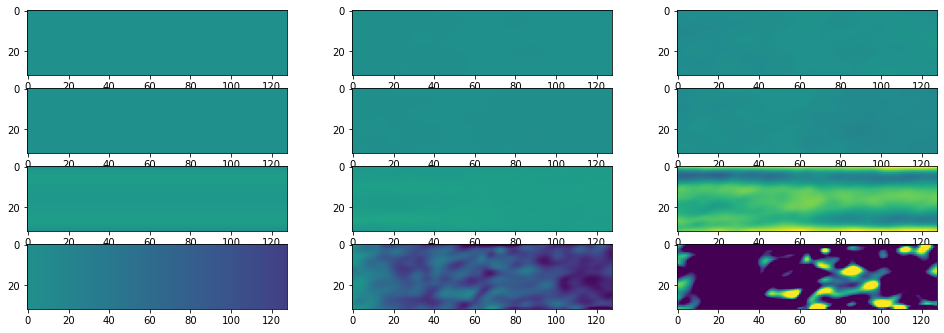

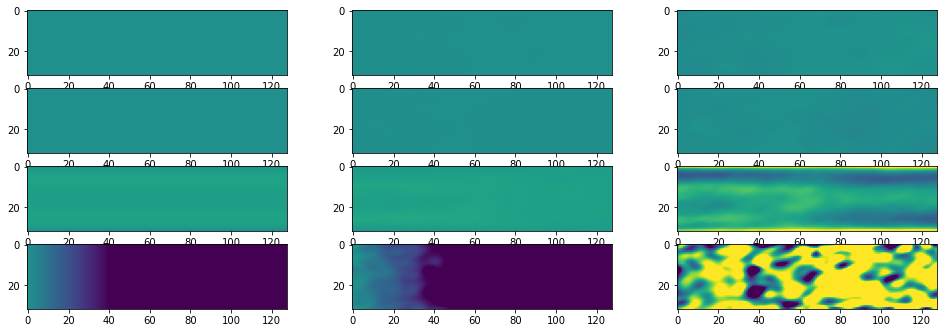

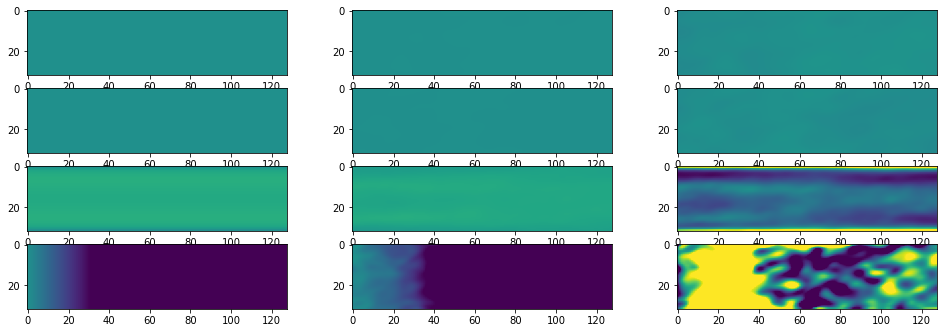

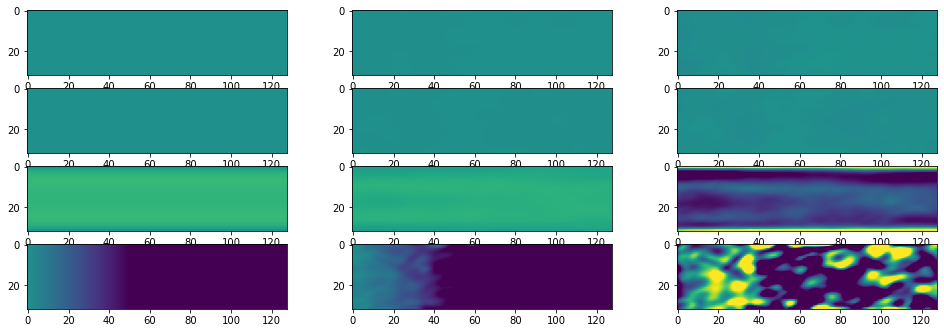

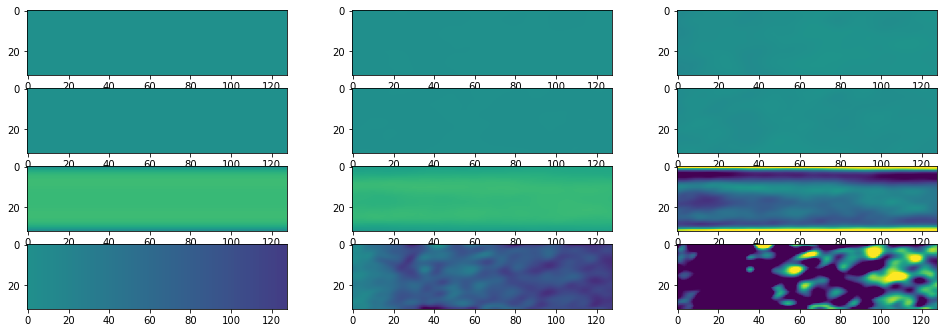

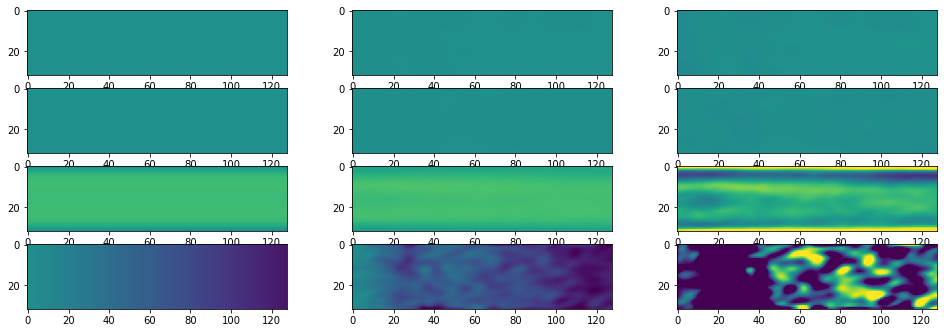

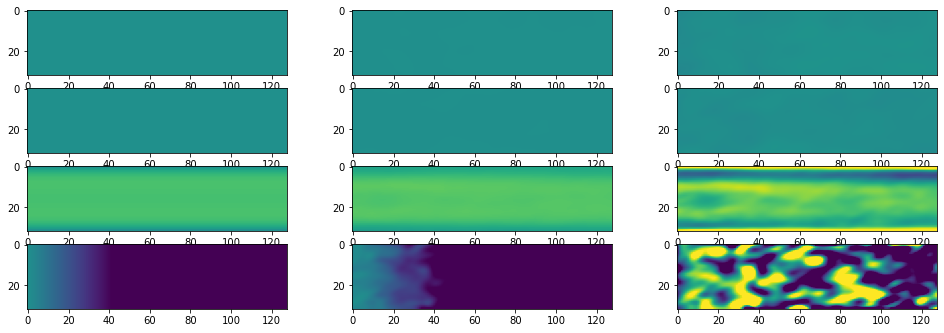

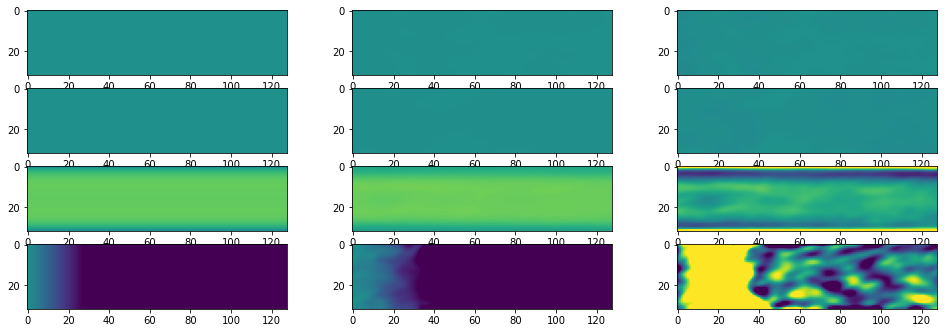

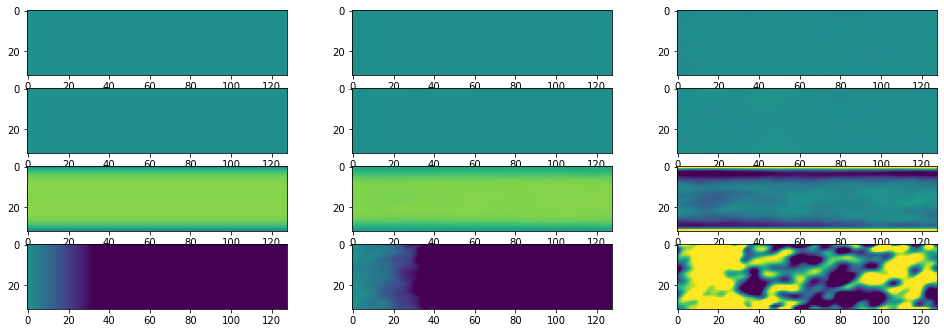

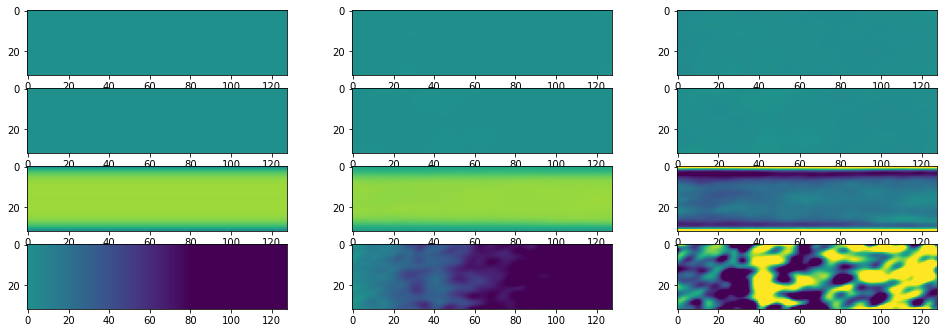

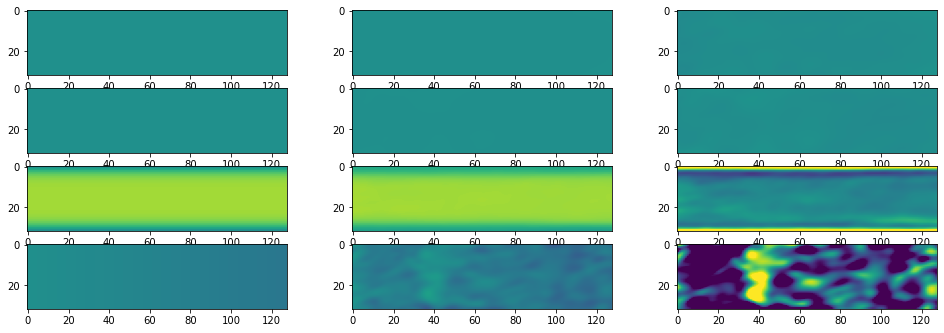

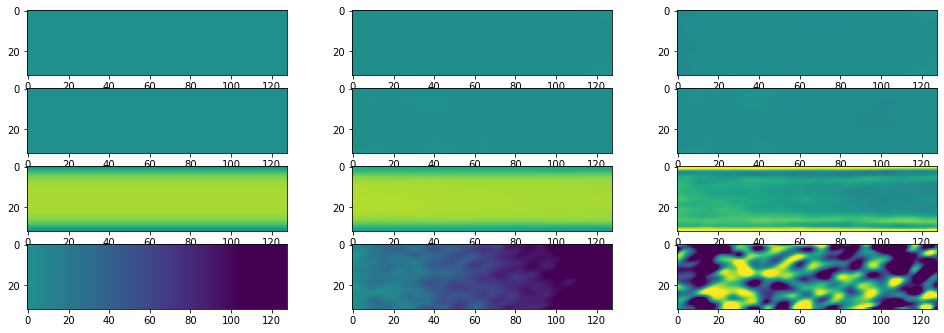

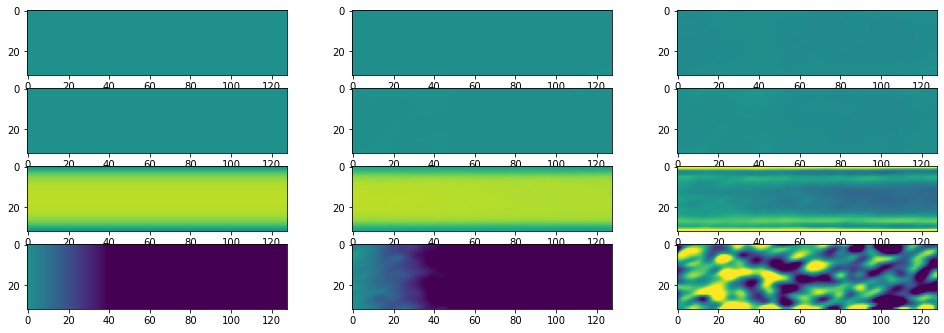

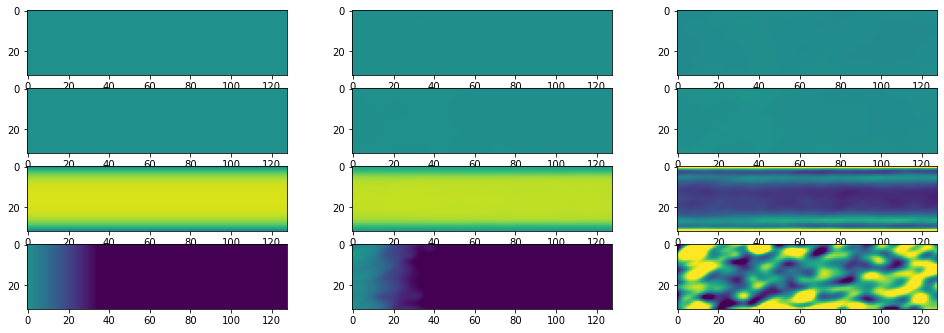

In [ ]:
Nxt = 32
Nzt = 4*Nxt
Ntt = 64

xt,yt,zt,tt = np.meshgrid(np.linspace(-1,1,Nxt),np.linspace(0,0,1),np.linspace(0,4,Nzt),np.linspace(0,1,Ntt))
ut,vt,wt = pipe.velocity(xt,yt,zt,tt)
pt = pipe.pressure(xt,yt,zt,tt)
ut = np.squeeze(ut[0,:,:,:])
vt = np.squeeze(vt[0,:,:,:])
wt = np.squeeze(wt[0,:,:,:])
pt = np.squeeze(pt[0,:,:,:])


Xt = np.concatenate((xt.reshape((Nxt*Nzt*Ntt,1)),yt.reshape((Nxt*Nzt*Ntt,1)),zt.reshape((Nxt*Nzt*Ntt,1)),tt.reshape((Nxt*Nzt*Ntt,1))),axis=1)
Xt = torch.from_numpy(Xt).float().cuda()
Fpt = net(Xt)

Fpt = Fpt.cpu().detach().numpy().reshape((Nxt,1,Nzt,Ntt,4))
upt = np.squeeze(Fpt[:,0,:,:,0])
vpt = np.squeeze(Fpt[:,0,:,:,1])
wpt = np.squeeze(Fpt[:,0,:,:,2])
ppt = np.squeeze(Fpt[:,0,:,:,3])
for tn in np.arange(Ntt):
    fig, axes = plt.subplots(4,3, figsize=(16.5,5.5))
    axes[0,0].imshow(ut[:,:,tn],vmin=-1,vmax=1)
    axes[0,1].imshow(upt[:,:,tn],vmin=-1,vmax=1)
    axes[0,2].imshow(upt[:,:,tn]-ut[:,:,tn],vmin=-0.1,vmax=0.1)
    
    axes[1,0].imshow(vt[:,:,tn],vmin=-1,vmax=1)
    axes[1,1].imshow(vpt[:,:,tn],vmin=-1,vmax=1)
    axes[1,2].imshow(vpt[:,:,tn]-vt[:,:,tn],vmin=-0.1,vmax=0.1)
    
    axes[2,0].imshow(wt[:,:,tn],vmin=-1,vmax=1)
    axes[2,1].imshow(wpt[:,:,tn],vmin=-1,vmax=1)
    axes[2,2].imshow(wpt[:,:,tn]-wt[:,:,tn],vmin=-0.1,vmax=0.1)
    
    axes[3,0].imshow(pt[:,:,tn],vmin=-1,vmax=1)
    axes[3,1].imshow(ppt[:,:,tn],vmin=-1,vmax=1)
    axes[3,2].imshow(ppt[:,:,tn]-pt[:,:,tn],vmin=-0.1,vmax=0.1)
    
    
    plt.show()

In [ ]:
2**20